# Depth estimation of mono-camera images for Visual SLAM 

In [1]:
# !unzip example_dataset.zip

In [1]:
!nvidia-smi

Wed May  5 21:34:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0  On |                  N/A |
| 25%   48C    P0    64W / 250W |    456MiB / 11175MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3080    Off  | 00000000:0A:00.0 Off |                  N/A |
| 52%   

In [2]:
import tensorflow as tf

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Dense, BatchNormalization, Dropout, MaxPool2D, Input, SeparableConv2D, Lambda, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import backend as K

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Let's try to create an Autoencoder network (UNET)

Unet has three parts:
- Downsampling   (skip connection to upsampling)
- Bottleneck
- Upsampling

In [6]:
# Use billinear additive upsampling (BAU) and separable convolution to reduce the total amount of hyperparameters
def BAU_layer(last_layer, channel_num):
    additive = []
    depth = int(last_layer.get_shape()[-1])
    step = int(depth / channel_num)
    last_layer[:, :, :, 1*step:(1*step+step)]
    for i in range(channel_num):
        layersum = K.mean(last_layer[:, :, :, i*step:(i*step+step)], axis = -1)
        additive.append(layersum)
    additive = K.stack(additive, axis = -1)
    return additive

def upsampling_step(skipped_conv, num_output_filters, prev_conv = None):
    num_filters = skipped_conv.output_shape[-1]
    up_sampling_1 = UpSampling2D((2,2))(prev_conv)
    if prev_conv != None:
        concat_layer = tf.keras.layers.concatenate([up_sampling_1, skipped_conv.output])
    else:
        concat_layer = skipped_conv.output
    conv1 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(concat_layer)
    conv2 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(conv1)
#     up = UpSampling2D()(conv2)
    BAU = Lambda(BAU_layer, arguments = {'channel_num': num_output_filters})(conv2)
    conv3 = SeparableConv2D(num_output_filters, 2, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(BAU)
    return conv3

def output(feature_map, mask = True):
    if mask:
        conv3 = Conv2D(7, 1, padding = 'same', activation = 'sigmoid', kernel_initializer = 'he_normal', name = 'masks')(feature_map)
    else:
        conv3 = Conv2D(1, 1, padding = 'same', activation = 'sigmoid', kernel_initializer = 'he_normal', name = 'edges')(feature_map)
    return conv3



In [7]:
resnet50 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

In [8]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
layer_names = [layer.name for layer in resnet50.layers]

In [10]:
layer_names.index('conv4_block1_1_conv')

81

In [11]:
layer_names.index('conv3_block1_1_conv')

39

In [12]:
layer_names.index('pool1_pool')

6

In [13]:
layer_names.index('conv1_relu')

4

In [14]:
layer_names.index('input_1')

0

In [5]:
def down_block(x, filters, kernel_s = (3,3), 
              padding_ = 'same', strides_ = 1, 
              activation_ = 'relu'):

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)
    x = BatchNormalization()(conv1_layer)
    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)

    pooling_layer = MaxPool2D((2,2), strides=(2,2))(conv2_layer)

    return conv2_layer, pooling_layer

def bottleneck(x, filters, kernel_s = (3,3), 
               padding_ = 'same', strides_ = 1, 
               activation_ = 'relu'):

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)

    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(conv1_layer)
    return conv2_layer
  

def up_block(x, skip, filters, kernel_s = (3,3), 
                     padding_ = 'same', strides_ = 1, 
                     activation_ = 'relu'):

    up_sampling_1 = UpSampling2D((2,2))(x)
    concat1 = Concatenate()([up_sampling_1, skip])

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(concat1)

    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(conv1_layer)
    return conv2_layer

def next_up_block(x, skip, filters, kernel_s = (3,3), 
                     padding_ = 'same', strides_ = 1, 
                     activation_ = 'relu', name='decoder'):

    x = UpSampling2D((2,2))(x)
    if skip is not None:
        x = Concatenate()([x, skip])

    conv1_layer = SeparableConv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, kernel_initializer='he_uniform',
                        activation=activation_)(x)

    conv2_layer = SeparableConv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, kernel_initializer='he_uniform',
                        activation=activation_)(conv1_layer)
    return conv2_layer

def resnet50_model(input_shape):
    inputs = Input(input_shape)

    '''Load pre-trained resnet50 '''
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs) # no classifier layers needed.
    
    '''Get shape of final output from resnet50'''
    resnet50_final_output_shape = resnet50.layers[-1].output.shape
    
    for layer in resnet50.layers:
        layer.trainable = True # Made this trainable
#     resnet50.summary()
#     keras.utils.plot_model(resnet50, show_shapes=True)
    
    skiplayers = [174, 142, 80, 38, 4]
    skip_enc = []
    for i in skiplayers:
        skip_enc.append(resnet50.layers[i])
    print(skip_enc)
    
    ''' Encoder '''
    s1 = resnet50.layers[4].output                      #128 ("input_1")
    s2 = resnet50.layers[6].output        #64, 64  filters  ("conv1_relu")
    s3 = resnet50.layers[39].output  #32, 256 filters  ("conv2_block3_out")
    s4 = resnet50.layers[81].output  #16, 512 filters  ("conv3_block4_out")
#     s4 = resnet50.layers[142].output  #8, 1024 filters  ("conv4_block6_out")
#     s5 = resnet50.layers[174].output  # 4, 1048
    
    ''' Bottleneck '''
#     pooling_layer = MaxPool2D((2,2), strides=(2,2))(s4)
#     bn = bottleneck(pooling_layer, filters = 1024)

    ''' Decoder '''
    decode_filters = int(resnet50_final_output_shape[-1])
    decoder = Conv2D(filters=decode_filters, kernel_size=1, padding='same', input_shape=resnet50_final_output_shape, name='decoder_conv_1')(resnet50.output)
    d1 = next_up_block(decoder, s4, int(decode_filters / 2), name='decoder_1')
    d2 = next_up_block(d1, s3, int(decode_filters / 4), name='decoder_2')
    d3 = next_up_block(d2, s2, int(decode_filters / 8), name='decoder_3')
    d4 = next_up_block(d3, s1, int(decode_filters / 16), name='decoder_4')
    d4 = next_up_block(d4, resnet50.layers[0].output, int(decode_filters/32), name='decoder_5')
#     d5 = next_up_block(d4, None, 16)

    outputs = Conv2D(1, kernel_size=(3,3), padding='same', activation='sigmoid', name='decoder_final_conv')(d4)
    outputs = Activation(activation='relu')(outputs)
    model = keras.models.Model(inputs, outputs)

    return model

# model.summary()
# keras.utils.plot_model(model, show_shapes=True)
'''
    Layer Number - size - filters
    Layer 3      - 64   - 64
    
'''

'\n    Layer Number - size - filters\n    Layer 3      - 64   - 64\n    \n'

In [9]:
# model.compile(optimizer='adam', loss='mse')
# model.summary()
# keras.utils.plot_model(model, show_shapes=True)

In [8]:
# finish this later on...
import tensorflow.keras as keras
from skimage.transform import resize
from PIL import Image
import numpy as np
import cv2
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, batch_size = 8, image_size = 128):
    self.batch_size = batch_size
    self.image_size = image_size
    self.max_depth = 1000.0
    
  def load(self, rgb_file, depth_file):
    image = cv2.imread(rgb_file)
    image = cv2.resize(image, (self.image_size, self.image_size)) # resize...
    depth = cv2.imread(depth_file, -1)
    depth = cv2.resize(depth, (self.image_size, self.image_size)) 
#     print(self.max_depth)
    image_normalized = image/np.max(image)
    depth_normalized = depth/np.max(depth) # double check the depth images!
    return image_normalized, depth_normalized

  def load_all(self, rgb_files, depth_files):
        images = []
        depths = []
        for i in range(len(rgb_files)):
            img, dpth = self.load(rgb_files[i], depth_files[i])
            images.append(img)
            depths.append(dpth)
        return np.array(images), np.array(depths)

In [9]:
# Get file names
rgb_images = os.listdir('train-data/rgb/')
rgb_images.sort()
rgb_images = [str('train-data/rgb/') + file for file in rgb_images]
depth_images = os.listdir('train-data/depth/')
depth_images.sort()
depth_images = [str('train-data/depth/') + file for file in depth_images]

test_size = 250
rgb_images_test = rgb_images[:test_size]
depth_images_test = depth_images[:test_size]

rgb_images_train = rgb_images[test_size:]
depth_images_train = depth_images[test_size:]

# Load data:

load_data = DataGenerator()

X_train, y_train = load_data.load_all(rgb_files=rgb_images_train, 
                                      depth_files=depth_images_train)

X_test, y_test = load_data.load_all(rgb_files=rgb_images_test, 
                                  depth_files=depth_images_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1359, 128, 128, 3) (1359, 128, 128)
(250, 128, 128, 3) (250, 128, 128)


In [51]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(y_train)))

False
False


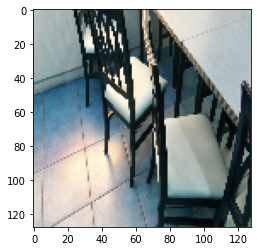

In [10]:
plt.imshow(X_train[80])

In [11]:
def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):
    
    y_true = tf.expand_dims(y_true, -1)
    y_pred = tf.expand_dims(y_pred, -1)
    
    # Point-wise depth
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

In [12]:
model = resnet50_model((128, 128, 3))
model.summary()

[<tensorflow.python.keras.layers.core.Activation object at 0x7f427439a128>, <tensorflow.python.keras.layers.core.Activation object at 0x7f42743e5ef0>, <tensorflow.python.keras.layers.core.Activation object at 0x7f42742e6f28>, <tensorflow.python.keras.layers.core.Activation object at 0x7f42743413c8>, <tensorflow.python.keras.layers.core.Activation object at 0x7f428a06b668>]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Con

In [13]:
model.compile(optimizer='adam', loss=depth_loss_function)

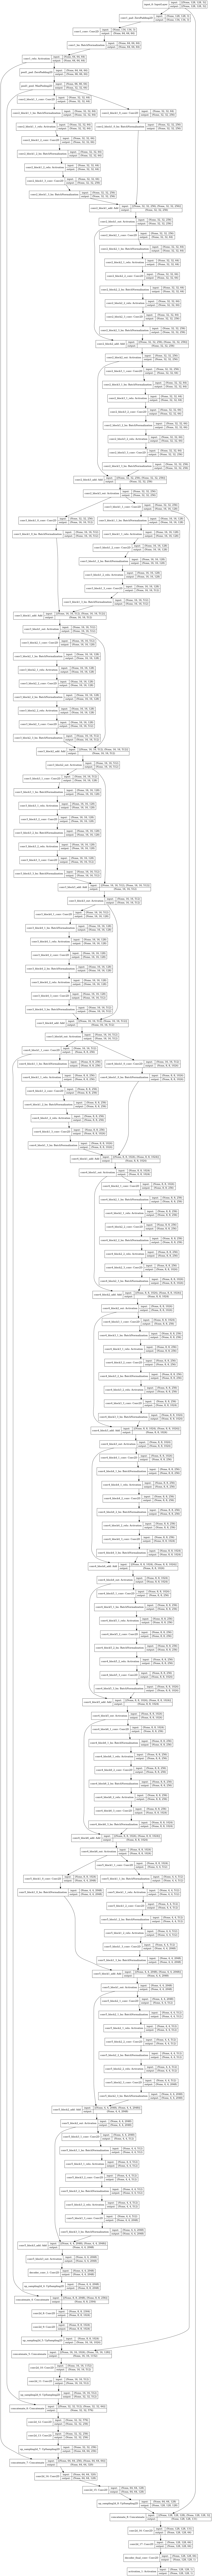

In [11]:
keras.utils.plot_model(model, show_shapes=True, to_file='resnet50-unet-conv.png')

In [16]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

In [15]:
# Create Model Checkpoint for tensorboard and saving checkpoints
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoint/',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True
)

In [17]:
# model.fit(X_train, y_train, batch_size=2, epochs=1000, validation_split=0.2, verbose=1, callbacks=[model_checkpoint_callback])
model.fit(X_train, y_train, batch_size=16, epochs=200, validation_split=0.2, verbose=1)

Epoch 1/200
68/68 [==============================] - 239s 2s/step - loss: 0.0911 - val_loss: 0.1229
Epoch 2/200
68/68 [==============================] - 9s 135ms/step - loss: 0.0915 - val_loss: 0.1228
Epoch 3/200
68/68 [==============================] - 9s 136ms/step - loss: 0.0909 - val_loss: 0.1201
Epoch 4/200
68/68 [==============================] - 9s 135ms/step - loss: 0.0908 - val_loss: 0.1176
Epoch 5/200
68/68 [==============================] - 10s 141ms/step - loss: 0.0900 - val_loss: 0.1168
Epoch 6/200
68/68 [==============================] - 9s 138ms/step - loss: 0.0895 - val_loss: 0.1170
Epoch 7/200
68/68 [==============================] - 9s 137ms/step - loss: 0.0890 - val_loss: 0.1159
Epoch 8/200
68/68 [==============================] - 9s 137ms/step - loss: 0.0892 - val_loss: 0.1155
Epoch 9/200
68/68 [==============================] - 9s 137ms/step - loss: 0.0891 - val_loss: 0.1180
Epoch 10/200
68/68 [==============================] - 9s 137ms/step - loss: 0.0889 - val_lo

In [18]:
preds = model.predict(X_test)

PREVIOUS UNET SIMPLE MODEL

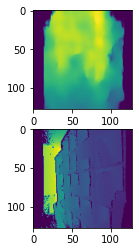

In [19]:
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(2,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(2,1,2)
plt.imshow(y_test[0]*255)

RESNET ENCODER MODEL RESULTS - not enough training!